In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.layers import merge
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# Remember to enable GPU
# %matplotlib inline

from models import *
from losses_and_metrics import *
from generators import *

import tensorflow as tf
from keras.optimizers import Adam, RMSprop

from glob import glob
from tqdm import tqdm

__READ_FROM_PICKLES__ = True

try:
    %load_ext autoreload
    %autoreload 2
except:
    pass

C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_HEIGHT=960
IMG_WIDTH=1280
IMG_CHANNELS=3

UNET_DEPTH = 6
UNET_INIT_FILTERS = 16

BATCH_SIZE = 1
LR_INIT = 1e-6
LR_MIN = 1e-9

### Read and Split Data Patho:

In [3]:
if __READ_FROM_PICKLES__:
    try:
        X = np.load("my_saved_files/X_patho.npy")
        Y = np.load("my_saved_files/Y_patho.npy")
        
    except:
        X_files = glob("Data_patho/ADENOMA 1 - 159/images/*")
        Y_files = glob("Data_patho/ADENOMA 1 - 159/tags/*")

        xs = []
        ys = []
        for fileX, fileY in tqdm(zip(X_files, Y_files)):
            xs.append(cv2.imread(fileX))
            ys.append(cv2.imread(fileY, 0))

        X = np.stack(xs)
        Y = np.expand_dims(np.stack(ys), axis=3)>128
        
        np.save("my_saved_files/X_patho.npy", X)
        np.save("my_saved_files/Y_patho.npy", Y)

    X_orig = X
    if X.max()>1.: X = X/255. - 0.5
#     X = (X*255).astype(int)
        
    print(X.shape, Y.shape)
    print(X.max(), Y.max())

(141, 960, 1280, 3) (141, 960, 1280, 1)
0.5 True


In [4]:
# from sys import getsizeof
# getsizeof(X)

#### Split to train/test/val

In [5]:
X_train, X_test_orig, Y_train, Y_test = train_test_split(X_orig, Y, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [6]:
i = 6
X_train = np.expand_dims(X[i], axis=0)
Y_train = np.expand_dims(Y[i], axis=0)

X_val= np.expand_dims(X[i], axis=0)
Y_val = np.expand_dims(Y[i], axis=0)

X_test = np.expand_dims(X[i], axis=0)
Y_test = np.expand_dims(Y[i], axis=0)

### Create Generator w/o Augmentations:

In [7]:
data_gen_args = dict(
#                         fill_mode="constant", # the new pixels filling method (options: ...) 
#                         cval=255,             # for fill_mode="constant", the value those pixels receives.
#                         height_shift_range=0.3, # randomly shifts the image up/down up to 30% of the image height 
                    )


gen = ImageDataGenerator(**data_gen_args)
gen.fit(X_train) # not really required here, until some augmentations rely on all data-set (X) data
gen = gen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=False)

gen_val = ImageDataGenerator(**data_gen_args)
gen_val.fit(X_train) # not really required here, until some augmentations rely on all data-set (X) data
gen_val = gen_val.flow(X_val, Y_val, batch_size=BATCH_SIZE, shuffle=False)

gen_test = ImageDataGenerator(**data_gen_args)
gen_test.fit(X_train) # not really required here, until some augmentations rely on all data-set (X) data
gen_test = gen_test.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# how to use this iterator:
x, y = gen.next()
x_val, y_val = gen_val.next()
print(x.shape, y.shape, x.max(), x.min(), y.max(), y.mean(), (x_val!=x).sum(), (y_val!=y).sum())

(1, 960, 1280, 3) (1, 960, 1280, 1) 0.34313726 -0.39411765 True 0.27641927083333334 0 0


In [9]:
def plot_image(img):
    parms_dict = {}
    if len(img.shape)==4 and img.shape[0]==1:
        img = img.squeeze(axis=0)
    if len(img.shape)==3 and img.shape[-1]==1:
        img = img.squeeze(axis=-1)
        parms_dict["cmap"] = plt.get_cmap("gray")

    if img.max()>1:
        img = img/255.
    plt.imshow(img, **parms_dict)

In [10]:
def plot_img_mask_maskPred(img, msk, mskP=None, figsize=(16,8)):
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(131)
    plot_image(img)
    plt.subplot(132)
    plot_image(msk)
    if mskP is not None:
        plt.subplot(133)
        plot_image(mskP)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


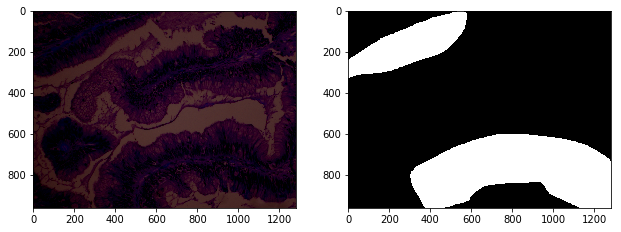

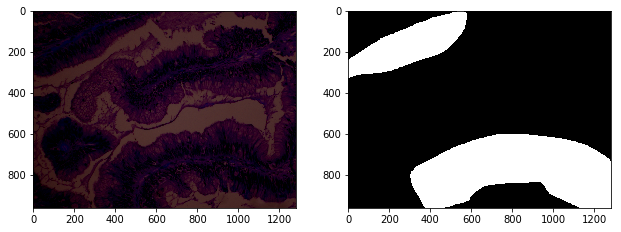

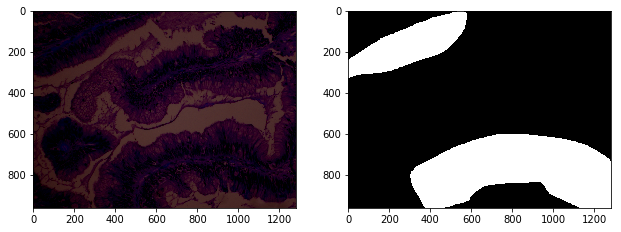

In [11]:
plot_img_mask_maskPred(*gen.next())
plot_img_mask_maskPred(*gen_val.next())
plot_img_mask_maskPred(*gen_test.next())

### Model: Create, Compile, Fit

In [12]:
unet = myUnetHP()
model = unet.build(n_depth_layers=UNET_DEPTH, n_init_filters=UNET_INIT_FILTERS, 
                   IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
l0_input (InputLayer)           (None, 960, 1280, 3) 0                                            
__________________________________________________________________________________________________
l0_normalize (Lambda)           (None, 960, 1280, 3) 0           l0_input[0][0]                   
__________________________________________________________________________________________________
enc_l1_1c (Conv2D)              (None, 960, 1280, 16 448         l0_normalize[0][0]               
__________________________________________________________________________________________________
enc_l1_2c (Conv2D)              (None, 960, 1280, 16 2320        enc_l1_1c[0][0]                  
__________________________________________________________________________________________________
enc_l1_3p 

__________________________________________________________________________________________________
dec_l5_1u (Conv2DTranspose)     (None, 480, 640, 32) 8224        dec_l4_4c[0][0]                  
__________________________________________________________________________________________________
dec_l5_2concat (Concatenate)    (None, 480, 640, 64) 0           dec_l5_1u[0][0]                  
                                                                 enc_l2_2c[0][0]                  
__________________________________________________________________________________________________
dec_l5_3c (Conv2D)              (None, 480, 640, 32) 18464       dec_l5_2concat[0][0]             
__________________________________________________________________________________________________
dec_l5_4c (Conv2D)              (None, 480, 640, 32) 9248        dec_l5_3c[0][0]                  
__________________________________________________________________________________________________
dec_l6_1u 

In [13]:
# Compile model:
model.compile(optimizer=RMSprop(lr = LR_INIT), loss='binary_crossentropy', metrics=[mean_iou])

In [14]:
checkpointer = ModelCheckpoint('model-patho2018-1.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.33, patience=20, min_lr=LR_MIN)

In [15]:
model.load_weights("model-patho2018-2-dph%d_flts%d_epochs12000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS))

In [ ]:
results = model.fit_generator(gen, epochs=3000, steps_per_epoch=1, #X_train.shape[0]//BATCH_SIZE, 
                              validation_data=gen_val, callbacks=[checkpointer, reduce_lr])

In [ ]:
model.save_weights("model-patho2018-2-dph%d_flts%d_epochs12000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS))

In [18]:
Y_pred = model.predict_generator(gen_test)
print(X_test.shape, Y_test.shape, Y_pred.shape)
print(X_test.max(), Y_test.max(), Y_pred.max())
print(Y_pred.min(), Y_pred.max())

ValueError: Tensor Tensor("conv2d_1/Sigmoid:0", shape=(?, 960, 1280, 1), dtype=float32) is not an element of this graph.

In [ ]:
t = 0.5
for i in range(X_test.shape[0]):
    plot_img_mask_maskPred(X_test[i]+0.5, Y_test[i], Y_pred[i]>0.5)

In [ ]:
mean_iou_np(Y_test[i], Y_pred[i], t=0.5)

In [16]:
tf.reset_default_graph()

In [17]:
y_pred = tf.placeholder(shape=Y_pred[i].shape, dtype=tf.bool)
y_true = tf.placeholder(shape=Y_test[i].shape, dtype=tf.bool)
score, up_opt = tf.metrics.mean_iou(y_true, y_pred, num_classes=2)
with tf.control_dependencies([up_opt]):
    score = tf.identity(score)

NameError: name 'Y_pred' is not defined

In [ ]:
# init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
with tf.Session() as sess:
#     sess.run(init_g)
    sess.run(init_l)
    print(Y_test[i].shape, Y_pred[i].shape)
    xx = sess.run(score, feed_dict={y_true:Y_test[i], y_pred:Y_pred[i]})
xx

In [ ]:
xx = mean_iou(y_pred, y_true)